In [ ]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import resnet50

from sklearn.metrics import classification_report, confusion_matrix
import scipy as sp

In [286]:
os.environ

environ({'COLAB_TPU_ADDR': '10.82.1.242:8470', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', 'CUDA_VERSION': '11.1.1', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'SHLVL': '0', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.7.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '8.0.5.39', 'LAST_FORCED_REBUILD': '20211007', 'JPY_PARENT_PID': '53', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""],"debugAdapterMultiplexerPath":"/usr/local/bin/dap_multiplexer","enableLsp":true}', 'ENV': '/root/.bashrc', 'GLI

In [ ]:
try:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    print('Running on TPU: ', tpu.cluster_spec().as_dict()['worker'])
    print('Number of accelerators: ', strategy.num_replicas_in_sync)

except ValueError:
    print('TPU failed to initialize.')

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.82.1.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.1.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU:  ['10.82.1.242:8470']
Number of accelerators:  8


In [ ]:
GCS_PATH = 'gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043'
print(GCS_PATH)

gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043


In [ ]:
!gsutil ls $GCS_PATH

gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/README.txt
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/Segmentation_example_script.m
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/license.txt
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/Fish_Dataset/
gs://kds-84d72844fcdf3e93f635a51c229600d46e76d474201c6ba89581d043/NA_Fish_Dataset/


In [ ]:
train_path = GCS_PATH + '/Fish_Dataset/Fish_Dataset/*/*/*'

In [ ]:
IMG_SIZE = [224, 224]
BATCH_SIZE = 128
VAL_SPLIT = 0.2
BUFFER_SIZE = 1024
CLASSES = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']

In [ ]:
def get_class(file_path):
    return tf.strings.split(file_path, os.path.sep)[-2]


def get_label(file_path):
    img_class = get_class(file_path)
    all_classes = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
    label = tf.convert_to_tensor(list(map((lambda x: int(x == img_class)), all_classes)))
    return label

def process_image(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float64) / 255.0
    return img, label


def load_dataset(file_path):
    image_dataset = tf.data.Dataset.list_files(file_path, shuffle = True)
    split = int(len(image_dataset) * VAL_SPLIT)

    valid_dataset = image_dataset.take(split)
    train_dataset = image_dataset.skip(split)

    train_dataset = train_dataset.filter(lambda x: tf.strings.split(get_class(x), ' ')[-1] != 'GT')
    train_dataset = train_dataset.map(process_image)

    valid_dataset = valid_dataset.filter(lambda x: tf.strings.split(get_class(x), ' ')[-1] != 'GT')
    valid_dataset = valid_dataset.map(process_image)
    return train_dataset, valid_dataset


def get_batched_dataset(dataset):
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder = False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset


def get_train_val_data(file_path):
    dataset = load_dataset(file_path)
    train = get_batched_dataset(dataset[0])
    val = get_batched_dataset(dataset[1])
    return train, val

In [293]:
train_data, valid_data = get_train_val_data(train_path)

In [ ]:
images = None
labels = None
for img, label in train_data.take(1):
    images = img
    labels = label

In [295]:
labels.numpy().shape

(128, 9)

In [296]:
images.shape

TensorShape([128, 224, 224, 3])

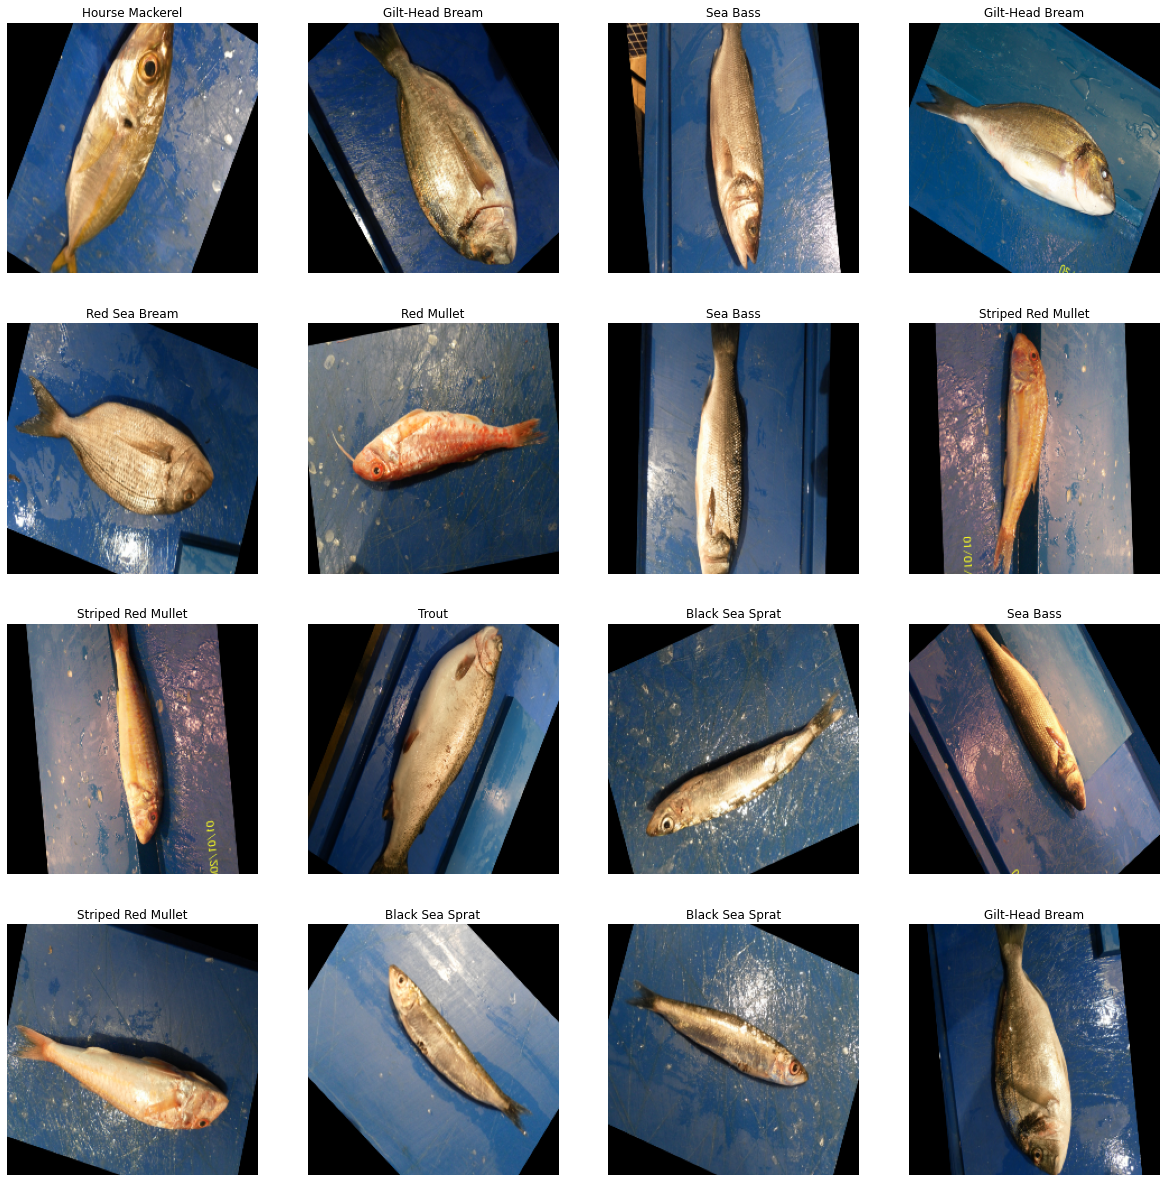

In [297]:
fig, axes = plt.subplots(4, 4, figsize = (20, 20))
axarr = axes.flat

for i, axis in enumerate(axarr):
  axis.imshow(images.numpy()[i, :, :, :])
  axis.set_title(CLASSES[np.argmax(labels.numpy()[i])])
  axis.axis('off')

plt.subplots_adjust(
    left=0.1,
    bottom = 0.1,
    right=0.9,
    top = 0.9,
    wspace=0.2,
    hspace = 0.2    
)

# Model Training

In [ ]:
with strategy.scope():

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape = (224, 224, 3)),
         
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
         
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
         
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
         
             tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
         
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
         
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
         
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name = 'feature_layer'),
        
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(9, activation = 'softmax', name = 'classifier')
        ]
    )

    loss_object = tf.keras.losses.CategoricalCrossentropy(
        reduction = tf.keras.losses.Reduction.NONE
    )

    def compute_loss(labels, predictions):       
        per_example_loss = loss_object(labels, predictions)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync)

    test_loss = tf.keras.metrics.Mean(name = 'test_loss')

    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')
    test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.001,
        decay_steps = 50,
        decay_rate = 0.95
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

    @tf.function
    def distributed_training_step(datasets_inputs):
        per_replica_losses = strategy.run(train_steps, args = (datasets_inputs, ))
        print(per_replica_losses)
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis = None)

    @tf.function
    def distributed_test_step(datasets_inputs):
        strategy.run(test_steps, args = (datasets_inputs, ))

    def train_steps(inputs):
        images, labels = inputs


        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = compute_loss(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_accuracy.update_state(labels, predictions)

        return loss

    def test_steps(inputs):
        images, labels = inputs

        predictions = model(images)
        loss = loss_object(labels, predictions)

        test_loss.update_state(loss)
        test_accuracy.update_state(labels, predictions)

In [299]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 222, 222, 8)       224       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 222, 222, 32)      2336      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 111, 111, 32)      9248      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 55, 55, 32)        9248      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 55, 55, 32)      

In [300]:
EPOCHS = 25
with strategy.scope():
    for epoch in range(EPOCHS):
        epoch_start = datetime.now()
        total_loss = 0.0
        num_batches = 0

        # Training Loop
        for x in train_data: 
            total_loss += distributed_training_step(x)
            num_batches += 1

        train_loss = total_loss / num_batches

        # Testing Loop
        for x in valid_data:
            distributed_test_step(x)

        epoch_end = datetime.now()
        
        template = ("Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, Test Accuracy: {:.2f}, \t Elapsed Time: {}")

        print(template.format(
            epoch + 1,
            train_loss,
            train_accuracy.result() * 100,
            test_loss.result() / strategy.num_replicas_in_sync,
            test_accuracy.result() * 100,
            (epoch_end - epoch_start).seconds
        ))

        test_loss.reset_states()
        train_accuracy.reset_states()
        test_accuracy.reset_states()

PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
PerReplica:{

## Save Model For Future Use and Evaluation

In [ ]:
model.save('../DataModel/hasil_model_training.h5')